100%|██████████| 100/100 [19:28<00:00, 11.69s/it]


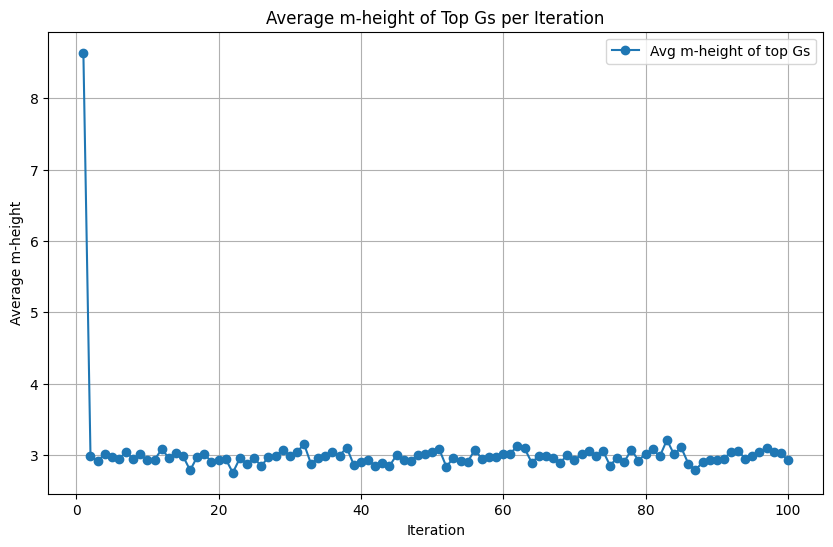

Best G matrices saved to best_Gs.pkl
Best G matrices and their m-heights:
G:
 [[-843 -297   73  989 -468 -726 -216  -76 -831 -216  702]
 [-347  420 -683  483  279 -123  493 -884  505  535  894]
 [-610 -573 -868  836 -288 -242  801  407 -492  839  198]
 [  87  820 -198  773 -121  424 -778 -363 -803 -539 -674]
 [ 703  551 -287  857 -614 -405 -818  709  608  419  896]
 [-835 -440 -932 -318 -966  790  331  -27 -420 -990 -146]] 
m-height: tensor(2.4795)
G:
 [[ 211  120   73 -923 -983 -722  401  742 -447 -278  707]
 [-759  744 -346  485  278 -534  493 -608 -272  536  -35]
 [-609 -307 -179  567  888 -242 -566  407  265  835  964]
 [  87  817 -196 -322 -443  423  851 -512  371 -540 -677]
 [-187  546 -289  857 -939 -380 -508  708  609 -515  895]
 [ 668 -296 -907  846 -969 -915  333 -351 -421 -675  -59]] 
m-height: tensor(2.4913)
G:
 [[ -636   920    73  -978  -468  -725   561  -787   768   700  -653]
 [   95   422  -681    73  -546  -536   492  -887   299  -539   -33]
 [ -608   773  -595   248 

In [1]:
import torch
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt


def store_best_G(best_G, filename="best_Gs.pkl"):
    with open(filename, "wb") as f:
        pickle.dump(best_G.cpu().numpy(), f)
    print(f"Best G matrices saved to {filename}")

# Function for generating a random full-rank matrix
def generate_full_rank_matrix(k, n, int_range=(-1000, 1000)):
    while True:
        G = np.random.randint(int_range[0], int_range[1] + 1, (k, n))
        if np.linalg.matrix_rank(G) == k:
            return torch.tensor(G)

# Function to calculate m-heights for a given G and X
def calculate_m_height(x_vectors, G, m):
    x_vectors = x_vectors.float()
    G = G.float()
    codewords = torch.matmul(x_vectors, G)
    abs_codewords = torch.abs(codewords)
    top_1_values = torch.amax(abs_codewords, dim=1)
    top_m_values, _ = torch.topk(abs_codewords, k=m + 1, dim=1, largest=True)
    mth_values = top_m_values[:, -1]
    mth_values = torch.clamp(mth_values, min=1e-8)  # Avoid division by zero
    return top_1_values / mth_values

# Generic mutation function
def mutate(tensor, mutation_range=(-1, 1),flag=0):
    if flag == 0:
      return tensor + torch.randint(mutation_range[0], mutation_range[1] + 1, tensor.shape, device=tensor.device)
    else:
      return tensor + torch.randn(tensor.shape, device=tensor.device)

# Generic crossover function
def crossover(tensorA, tensorB, perturbation_range=(-1, 1)):

    mask = torch.randint(0, 2, tensorA.shape, device=tensorA.device, dtype=torch.bool)
    result = torch.where(mask, tensorA, tensorB)
    perturbation = torch.randint(perturbation_range[0], perturbation_range[1] + 1, tensorA.shape, device=tensorA.device)
    return result + perturbation

# Function to optimize X for a given G
def optimize_X_for_G(x_vectors, G, k, m, iterations=1000, top_x_count=50):
    global_best_xs = torch.empty((0, k), device=x_vectors.device)
    global_best_m_heights = torch.empty(0, device=x_vectors.device)

    for _ in range(iterations):
        m_heights = calculate_m_height(x_vectors, G, m)
        sorted_indices = torch.argsort(m_heights, descending=True)
        top_xs = x_vectors[sorted_indices[:top_x_count]]
        top_m_heights = m_heights[sorted_indices[:top_x_count]]

        # Update global best
        if global_best_xs.numel() == 0:
            global_best_xs = top_xs
            global_best_m_heights = top_m_heights
        else:
            combined_xs = torch.cat([global_best_xs, top_xs])
            combined_m_heights = torch.cat([global_best_m_heights, top_m_heights])
            sorted_indices = torch.argsort(combined_m_heights, descending=True)
            global_best_xs = combined_xs[sorted_indices[:top_x_count]]
            global_best_m_heights = combined_m_heights[sorted_indices[:top_x_count]]

        # Create new pool
        random_xs = torch.randn(top_xs.shape, device=top_xs.device)
        mutated_xs = mutate(top_xs, mutation_range=(-1, 1), flag = 1)
        i, j = torch.triu_indices(top_x_count, top_x_count, 1, device=top_xs.device)
        crossover_xs = crossover(top_xs[i], top_xs[j])
        x_vectors = torch.cat([random_xs, mutated_xs, crossover_xs, top_xs])

    return global_best_xs[:5], global_best_m_heights[:5]

# Unified optimization function for G and X
def optimize_G_and_X(k, n, m, G_population_size=100, x_vector_count=10000,
                     iterations=10, G_top_count=20, G_mutation_range=(-1, 1)):
    # Initialize G population and X vectors
    G_population = torch.stack([generate_full_rank_matrix(k, n) for _ in range(G_population_size)]).to('cuda')
    x_vectors = torch.randn(x_vector_count, k, device='cuda')

    best_Gs = torch.empty((0, k, n), device='cuda')
    best_m_heights = []
    avg_m_heights_per_iteration = []

    for iteration in tqdm(range(iterations)):
        # Phase 1: Optimize G matrices
        G_m_heights = torch.tensor([calculate_m_height(x_vectors, G, m).max().item() for G in G_population])
        sorted_indices = torch.argsort(G_m_heights)
        top_Gs = G_population[sorted_indices[:G_top_count]]
        top_m_heights = G_m_heights[sorted_indices[:G_top_count]]

        avg_m_heights_per_iteration.append(top_m_heights.mean().item())

        # Genetic programming for G
        mutated_Gs = mutate(top_Gs, mutation_range=G_mutation_range, flag = 0)
        i, j = torch.triu_indices(G_top_count, G_top_count, 1, device=top_Gs.device)
        crossover_Gs = torch.vstack([crossover(top_Gs[i], top_Gs[j])])
        random_Gs = torch.stack([generate_full_rank_matrix(k, n) for _ in range(G_top_count)]).to('cuda')
        G_population = torch.cat([mutated_Gs, crossover_Gs, top_Gs, random_Gs])

        # Phase 2: Optimize X vectors for each top G
        refined_x_vectors = []
        for G in top_Gs:
            best_xs, _ = optimize_X_for_G(x_vectors, G, k, m)
            refined_x_vectors.append(best_xs)

        # Update X vector pool
        x_vectors = torch.cat(refined_x_vectors, dim=0)

        # Update best Gs
        best_Gs = top_Gs
        best_m_heights = top_m_heights

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, iterations + 1), avg_m_heights_per_iteration, marker='o', label="Avg m-height of top Gs")
    plt.xlabel("Iteration")
    plt.ylabel("Average m-height")
    plt.title("Average m-height of Top Gs per Iteration")
    plt.legend()
    plt.grid()
    plt.show()

    return best_Gs, best_m_heights

# Parameters
k, n, m = 6, 11, 4  # Example dimensions
G_population_size = 100
x_vector_count = 10000
iterations = 100
G_top_count = 20
G_mutation_range = (-10, 10)

# Run optimization
best_Gs, best_m_heights = optimize_G_and_X(k, n, m, G_population_size, x_vector_count,
                                            iterations, G_top_count, G_mutation_range)

store_best_G(best_Gs[0])

# Output results
print("Best G matrices and their m-heights:")
for G, height in zip(best_Gs, best_m_heights):
    print("G:\n", G.cpu().numpy(), "\nm-height:", height)